In [37]:
#First out imports
#Lets import some stuff!

#Numpy
import numpy as np

#Cartopy for mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


#Matplotlib for plotting
import matplotlib.pyplot as plt

#Siphon for finding data
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

#date tools
from datetime import datetime, timedelta
from netCDF4 import num2date

#os tools
import os

%matplotlib inline

In [43]:
#UNIDATA thredds location 
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'

# parse the xml
metar_cat = TDSCatalog(metar_cat_url)

# what datasets are here? only one "dataset" in this catalog
dataset = list(metar_cat.datasets.values())[0]
ncss_url = dataset.access_urls["NetcdfSubset"]
ncss = NCSS(ncss_url)


In [61]:
#Bounding box for our query
# 42.3479262,-71.1334236,11.74z

#create a new query for the server

#query = ncss.query().accept('csv').time(datetime.utcnow() - timedelta(minutes=1))
query = ncss.query().accept('csv').time_range(datetime.utcnow() - timedelta(days=0.5),
                                             datetime.utcnow() - timedelta(minutes=5))
query.lonlat_box(**bb)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather', 'report_id')


data = ncss.get_data(query)
#Pass the bounding box through
#query.lonlat_box(**bb)

#what measurements do we want?
#query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
#                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather',
#               'report_id', 'precipitation_amount_hourly', 'precipitation_amount_24')

#restrict to last 1200 hours.. that should be enough data
#query.time_range(datetime(2018, 8, 3) , datetime(2018, 9, 1) )
#query.accept('csv')

#run the query!
#data = ncss.get_data(query)


HTTPError: Error accessing http://thredds.ucar.edu/thredds/ncss/nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr?var=wind_speed&var=weather&var=dew_point_temperature&var=report_id&var=cloud_area_fraction&var=wind_from_direction&var=inches_ALTIM&var=air_temperature&time_start=2018-09-07T03%3A17%3A09.613948&time_end=2018-09-07T15%3A12%3A09.613958&west=-170.0&east=-140.0&south=60.0&north=75&accept=csv
Server Error (502: badgateway)

In [47]:
#Two seperate dictionaries for the data and its locations
station_dict={}
locs ={}

#What variables do we want to extract as data points
want = ('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather', 'report_id')


#want = ('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
#                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather',
#       'precipitation_amount_hourly', 'precipitation_amount_24')

#determine the names of the unique stations
stations = np.unique(data['report_id'])

#Loop over each station
for station in stations:
    #identify where in the returned array the station we
    #are interested is.
    wstat = np.where(data['report_id'] == station)
    
    #Grab lat, lon and print and update locs dic
    lat = np.unique(data['latitude'][wstat])
    lon = np.unique(data['longitude'][wstat])
    print(station, lat, lon)
    locs.update({station.decode('UTF-8'): (lat, lon)})
    
    #create a list of python datetime objects from date string
    dates_list = [datetime.strptime(date.decode('UTF-8'), "%Y-%m-%dT%H:%M:%SZ") for date in data['time'][wstat]]
    
    #Create a list of indexes that we can use to sort each station's data by time
    arrrrg = np.array(dates_list).argsort()
    this = {}
    
    #for each variable update the station dictionary with the data
    for key in want:
        this.update({key:data[key][wstat][arrrrg]})
    
    #Add time, time strings and add this station to the master station
    #dictionary
    this.update({'time': np.array(dates_list)[arrrrg]} )
    this.update({'timestr': data['time'][wstat][arrrrg]})
    station_dict.update({station.decode('UTF-8'):this})

b'EDDC' [61.13] [-146.25]
b'EGLL' [64.819] [-147.869]
b'EHEH' [61.529 66.87 ] [-166.149 -162.63 ]
b'KBNW' [65.169] [-152.1]
b'KDLN' [66.919] [-151.52]
b'KEWB' [64.5] [-165.429]
b'KFFC' [70.129] [-143.58]
b'KFMY' [64.819] [-147.869]
b'KHCO' [64.779] [-141.149]
b'KIND' [61.419 66.919] [-151.52 -149.52]
b'LSGS' [61.22] [-149.85]
b'PAAQ' [61.599] [-149.08]
b'PABA' [70.129] [-143.58]
b'PABE' [60.779] [-161.8]
b'PABI' [63.97] [-145.699]
b'PABL' [65.989] [-161.119]
b'PABR' [71.3] [-156.779]
b'PABT' [66.919] [-151.52]
b'PABV' [61.419] [-149.52]
b'PACM' [61.849] [-165.57]
b'PACV' [60.5] [-145.5]
b'PACZ' [61.779] [-166.029]
b'PADE' [66.08] [-162.75]
b'PADM' [61.86] [-162.029]
b'PAED' [61.25] [-149.8]
b'PAEG' [64.779] [-141.149]
b'PAEI' [64.669] [-147.1]
b'PAEM' [62.77] [-164.5]
b'PAEN' [60.569] [-151.25]
b'PAFA' [64.819] [-147.869]
b'PAFB' [64.83] [-147.619]
b'PAFM' [67.099] [-157.85]
b'PAFS' [63.02] [-154.36]
b'PAGA' [64.73] [-156.929]
b'PAGK' [62.15] [-145.449]
b'PAHP' [61.529] [-166.149]
b'PA

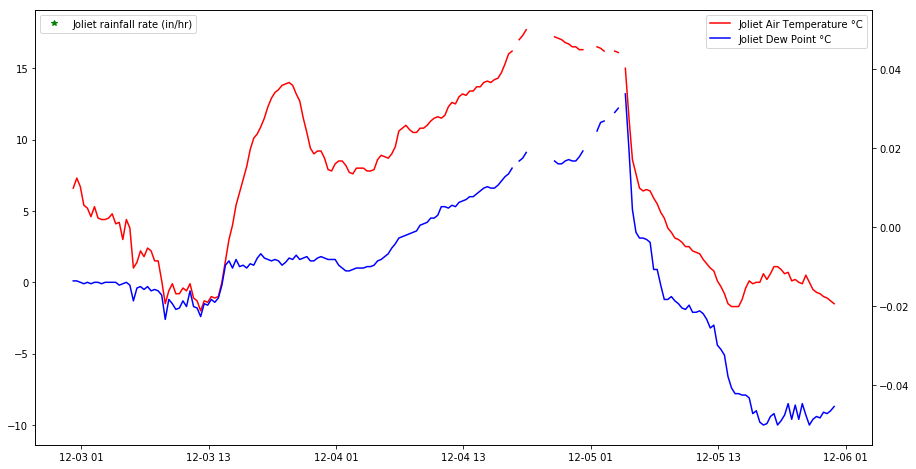

In [62]:

#make a nice visual!
fig = plt.figure(figsize = [15,8])
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['air_temperature'], 
         'r-', label=u'Joliet Air Temperature \u00b0C')
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['dew_point_temperature'], 
         'b-', label=u'Joliet Dew Point \u00b0C')
plt.legend()
ax2= plt.twinx()
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['precipitation_amount_hourly'], 'g*',
        label='Joliet rainfall rate (in/hr)')
plt.legend(loc=2)
plt.savefig('../images/KLOT.png')

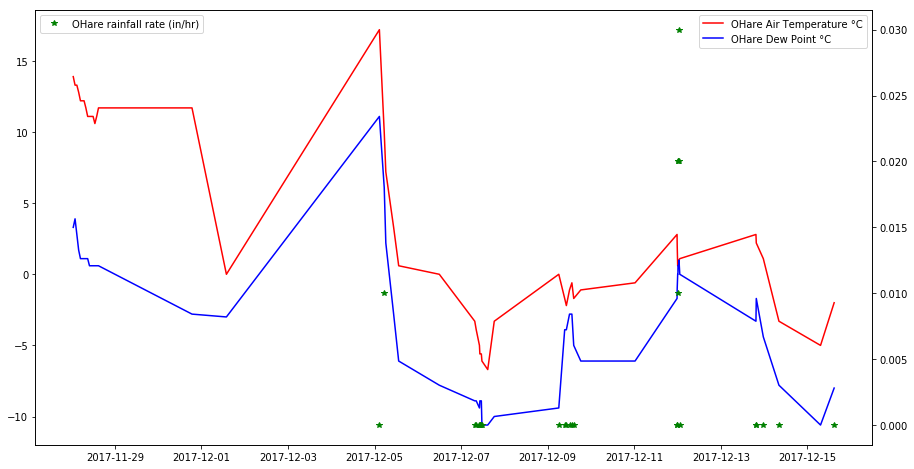

In [38]:

#make a nice visual!
fig = plt.figure(figsize = [15,8])
plt.plot(station_dict['KMDW']['time'], 
         station_dict['KMDW']['air_temperature'], 
         'r-', label=u'OHare Air Temperature \u00b0C')
plt.plot(station_dict['KMDW']['time'], 
         station_dict['KMDW']['dew_point_temperature'], 
         'b-', label=u'OHare Dew Point \u00b0C')
plt.legend()
ax2= plt.twinx()
plt.plot(station_dict['KMDW']['time'], 
         station_dict['KMDW']['precipitation_amount_hourly'], 'g*',
        label='OHare rainfall rate (in/hr)')
plt.legend(loc=2)
plt.savefig('../images/KORD.png')

In [48]:
#Where to save the data.. and create a header for each CSV file
out_dir = '/Users/scollis/funded_projects/precip_change/data/'
headers = ''
for key in list(station_dict[list(station_dict.keys())[0]].keys()):
    headers += key +","
headers = headers[:-1]+'\n'

#For each station create a CSV file of the data
for key in station_dict.keys():
    print(key)
    fh = open(os.path.join(out_dir, key+'.csv'), 'w')
    fh.write(headers)
    varss = list(station_dict[key].keys())
    for i in range(len(station_dict[key][varss[0]])):
        this_line =''
        for vkey in varss:
            this_line += str(station_dict[key][vkey][i])+','
        this_line = this_line[:-1]+'\n'
        fh.write(this_line)
    fh.close()



EDDC
EGLL
EHEH
KBNW
KDLN
KEWB
KFFC
KFMY
KHCO
KIND
LSGS
PAAQ
PABA
PABE
PABI
PABL
PABR
PABT
PABV
PACM
PACV
PACZ
PADE
PADM
PAED
PAEG
PAEI
PAEM
PAEN
PAFA
PAFB
PAFM
PAFS
PAGA
PAGK
PAHP
PAIM
PAIN
PAKK
PAKP
PAKU
PAKV
PALG
PALH
PALJ
PALP
PALU
PAMC
PAMH
PAMK
PAMO
PAMR
PANC
PANI
PANN
PANV
PAOM
PAOO
PAOR
PAOT
PAPO
PAQT
PARC
PARS
PARY
PASC
PASK
PASL
PASM
PASV
PASX
PATA
PATC
PATK
PATL
PATO
PAUN
PAVD
PAVL
PAWD
PAWI
PAWN
PAWS
PAZK
PFYU
PHKO
PPIZ
RJOI
VTCC


In [49]:
high_res = {}
for st in station_dict.keys():
    npts = len(station_dict[st]['time'])
    print(st, npts)
    if npts > 10:
        high_res.update({st : station_dict[st]})
        high_res[st].update({'station': [st] * npts})
        high_res[st]['lat'] = list(locs[st][0]) * npts
        high_res[st]['lon'] = list(locs[st][1]) * npts


EDDC 1
EGLL 1
EHEH 2
KBNW 1
KDLN 1
KEWB 1
KFFC 1
KFMY 1
KHCO 1
KIND 2
LSGS 1
PAAQ 8
PABA 15
PABE 8
PABI 8
PABL 26
PABR 30
PABT 8
PABV 11
PACM 11
PACV 10
PACZ 13
PADE 10
PADM 8
PAED 13
PAEG 15
PAEI 25
PAEM 12
PAEN 8
PAFA 8
PAFB 9
PAFM 8
PAFS 8
PAGA 8
PAGK 8
PAHP 4
PAIM 10
PAIN 16
PAKK 8
PAKP 20
PAKU 4
PAKV 8
PALG 8
PALH 8
PALJ 1
PALP 3
PALU 8
PAMC 6
PAMH 10
PAMK 7
PAMO 23
PAMR 9
PANC 8
PANI 8
PANN 13
PANV 2
PAOM 8
PAOO 9
PAOR 8
PAOT 8
PAPO 15
PAQT 14
PARC 8
PARS 8
PARY 13
PASC 9
PASK 8
PASL 5
PASM 24
PASV 13
PASX 8
PATA 8
PATC 8
PATK 8
PATL 9
PATO 8
PAUN 8
PAVD 9
PAVL 7
PAWD 8
PAWI 11
PAWN 6
PAWS 3
PAZK 12
PFYU 9
PHKO 1
PPIZ 8
RJOI 1
VTCC 1


In [50]:
high_res

{'PABA': {'air_temperature': array([-2.2, -1.7, -1.7, -2. , -2.2, -2. , -2. , -2. , -2.2, -2.8, -2.2,
         -2. , -2. , -2. , -2.2]),
  'dew_point_temperature': array([-3.3, -3.3, -3.3, -3. , -3.3, -3. , -3. , -3. , -3.3, -4.4, -3.3,
         -3. , -3. , -3. , -3.3]),
  'inches_ALTIM': array([30.45, 30.45, 30.46, 30.46, 30.46, 30.46, 30.46, 30.47, 30.47,
         30.47, 30.47, 30.47, 30.47, 30.47, 30.46]),
  'wind_speed': array([2.057776, 2.057776, 2.057776, 3.086664, 2.57222 , 2.57222 ,
         2.57222 , 3.601108, 2.57222 , 2.57222 , 0.      , 0.      ,
         0.      , 0.      , 0.      ]),
  'wind_from_direction': array([310, 260, 310, 320, 300, 310, 320, 320, 310, 310,   0,   0,   0,
           0,   0]),
  'cloud_area_fraction': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'weather': array([b'', b'', b'', b'', b'-SN', b'-SN BR', b'-SN BR', b'-SN BR', b'',
         b'', b'-SN BR', b'-SN BR', b'-SN BR', b'-SN BR', b'-SN'],
        dtype='|S8'),
  'repo

In [51]:
#Where to save the data.. and create a header for each CSV file
out_dir = '/Users/scollis/funded_projects/precip_change/data/highres2/'
headers = ''
for key in list(high_res[list(high_res.keys())[0]].keys()):
    headers += key +","
headers = headers[:-1]+'\n'

#For each station create a CSV file of the data
for key in high_res.keys():
    print(key)
    fh = open(os.path.join(out_dir, key+'.csv'), 'w')
    fh.write(headers)
    varss = list(high_res[key].keys())
    for i in range(len(high_res[key][varss[0]])):
        this_line =''
        for vkey in varss:
            this_line += str(high_res[key][vkey][i])+','
        this_line = this_line[:-1]+'\n'
        fh.write(this_line)
    fh.close()

PABA
PABL
PABR
PABV
PACM
PACZ
PAED
PAEG
PAEI
PAEM
PAIN
PAKP
PAMO
PANN
PAPO
PAQT
PARY
PASM
PASV
PAWI
PAZK


In [54]:
locs

{'EDDC': (array([61.13]), array([-146.25])),
 'EGLL': (array([64.819]), array([-147.869])),
 'EHEH': (array([61.529, 66.87 ]), array([-166.149, -162.63 ])),
 'KBNW': (array([65.169]), array([-152.1])),
 'KDLN': (array([66.919]), array([-151.52])),
 'KEWB': (array([64.5]), array([-165.429])),
 'KFFC': (array([70.129]), array([-143.58])),
 'KFMY': (array([64.819]), array([-147.869])),
 'KHCO': (array([64.779]), array([-141.149])),
 'KIND': (array([61.419, 66.919]), array([-151.52, -149.52])),
 'LSGS': (array([61.22]), array([-149.85])),
 'PAAQ': (array([61.599]), array([-149.08])),
 'PABA': (array([70.129]), array([-143.58])),
 'PABE': (array([60.779]), array([-161.8])),
 'PABI': (array([63.97]), array([-145.699])),
 'PABL': (array([65.989]), array([-161.119])),
 'PABR': (array([71.3]), array([-156.779])),
 'PABT': (array([66.919]), array([-151.52])),
 'PABV': (array([61.419]), array([-149.52])),
 'PACM': (array([61.849]), array([-165.57])),
 'PACV': (array([60.5]), array([-145.5])),
 'P

EHEH  went wrong
KIND  went wrong


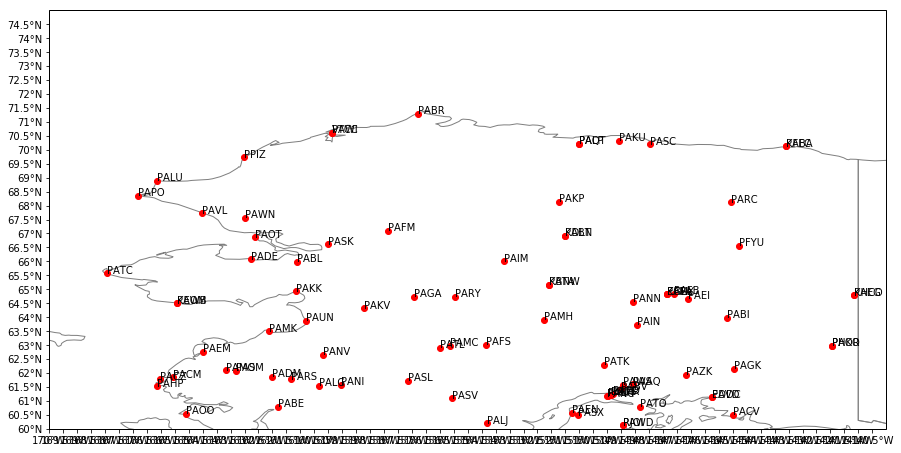

In [57]:

#Just to make sure, lets plot the location of all our METARS
tk = .5
north = bb['north']
south = bb['south']
west = bb['west']
east = bb['east']
bbox = [west, east, south,north]

fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(west, east, tk), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(south, north, tk), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent(bbox)
ax.add_feature(cfeature.LAKES, edgecolor='k')
ax.add_feature(cfeature.RIVERS)
states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
_ = ax.add_feature(states, edgecolor='gray')
for station_name in list(locs.keys()):
    if len(locs[station_name][1]) == 1 and len(locs[station_name][0]) == 1: 
        ax.plot(locs[station_name][1], locs[station_name][0], 'ro')
        ax.text(locs[station_name][1], locs[station_name][0], station_name)
    else:
        print(station_name, ' went wrong')
plt.savefig('../images/locations_alaska.png')

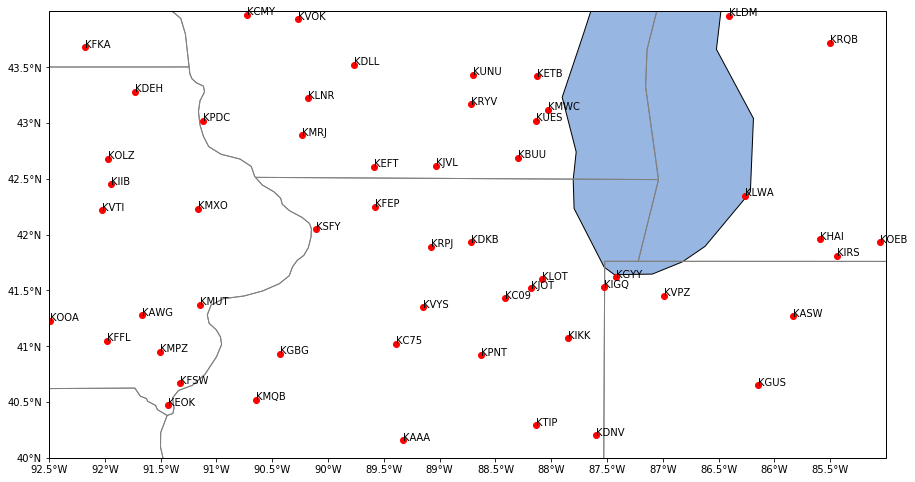

In [51]:

#Just to make sure, lets plot the location of all our METARS
tk = .5
north = bb['north']
south = bb['south']
west = bb['west']
east = bb['east']
bbox = [west, east, south,north]

fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(west, east, tk), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(south, north, tk), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent(bbox)
ax.add_feature(cfeature.LAKES, edgecolor='k')
ax.add_feature(cfeature.RIVERS)
states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
_ = ax.add_feature(states, edgecolor='gray')
for station_name in list(high_res.keys()):
    ax.plot(high_res[station_name]['loc'][1], high_res[station_name]['loc'][0], 'ro')
    ax.text(high_res[station_name]['loc'][1], high_res[station_name]['loc'][0], station_name)
plt.savefig('../images/locations_midwest_highres.png')